# Positioning project

In [70]:
# import libraries
import pandas as pd
import numpy as np
import scipy.fftpack
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, cross_val_score
%matplotlib inline


In [71]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [72]:
def statfeatureextract(data_sliced, num_sample):
    order = 5
    cutoff = 20
    fs = num_sample/10
    lowcut = 0.1
    highcut = 20
    if flag_lowpass == 1:
        x_filtered = butter_lowpass_filter(data_sliced.x, cutoff, fs, order)
        y_filtered = butter_lowpass_filter(data_sliced.y, cutoff, fs, order)
        z_filtered = butter_lowpass_filter(data_sliced.z, cutoff, fs, order)
    else:
        x_filtered = butter_bandpass_filter(data_sliced.x, lowcut, highcut, fs, order)
        y_filtered = butter_bandpass_filter(data_sliced.y, lowcut, highcut, fs, order)
        z_filtered = butter_bandpass_filter(data_sliced.z, lowcut, highcut, fs, order)
    x_mean = x_filtered.mean()
    x_var = x_filtered.var()
    y_mean = y_filtered.mean()
    y_var = y_filtered.var()
    z_mean = z_filtered.mean()
    z_var = z_filtered.var()
    return {"num_sample": int(data_sliced.shape[0]),"x_mean":x_mean, "x_var":x_var , "y_mean": y_mean, 
            "y_var": y_var, "z_mean": z_mean, "z_var": z_var}

def createstatfeature(data, activity):
#   remove outliner
    data.loc[data.x > 30, "x"] = 30
    data.loc[data.y > 30, "y"] = 30
    data.loc[data.z > 30, "z"] = 30
    data.loc[data.x < -30, "x"] = -30
    data.loc[data.y < -30, "y"] = -30
    data.loc[data.z < -30, "z"] = -30
    
    time_diff = 10000
    samplesper10sec = []
    statfeature = pd.DataFrame([])
    count = 0
    # if time index is a constant, we'll assume it samples at 250 Hz
    if data.time[0] == data.time[1]:
        data.time = np.arange(data.time[0], data.time[0] + 4*len(data.time) ,4)
    # slice data into 10 second period and extract statistical features.
    while len(data.time) > 1500:
        num_sample = np.sum(np.less_equal(data.loc[:, 'time'], 
                                          data.time[0]+time_diff))
        samplesper10sec.append(num_sample)
        data_sliced = data.loc[range(num_sample),:]
        statfeature = statfeature.append(statfeatureextract(data_sliced, num_sample), ignore_index=True)
        data.drop(range(num_sample), inplace = True)
        data.reset_index(drop=True, inplace = True)
        
    # add label to extracted features dataframe. 
    labeldict = {'laying_down':1, 'sitting':2, 'standing':3, 'walking':4}
    num_period = len(statfeature.x_mean)
    labels = pd.DataFrame({'activity_name': [activity]*num_period, 
                           'activity_label': [labeldict[activity]]*num_period})
    # # statfeature.
    result = pd.concat([statfeature, labels], axis = 1)
    return result

In [73]:
headername = ["time", "x", "y", "z", "ind", "label"]
flag_lowpass = 1
data = pd.read_csv('data/train/layingdown/1_android.sensor.accelerometer.data.csv',names = headername)
df1 = createstatfeature(data, "laying_down")
data = pd.read_csv('data/train/sitting/1_android.sensor.accelerometer.data.csv',names = headername)
df2 = createstatfeature(data, "sitting")
data = pd.read_csv('data/train/standing/1_android.sensor.accelerometer.data.csv',names = headername)
df3 = createstatfeature(data, "standing")
data = pd.read_csv('data/train/walking/1_android.sensor.accelerometer.data.csv',names = headername)
df4 = createstatfeature(data, "walking")

data_test = pd.read_csv('data/test/layingdown/1_android.sensor.accelerometer.data.csv',names = headername)
df1_test = createstatfeature(data_test, "laying_down")
data_test = pd.read_csv('data/test/sitting/1_android.sensor.accelerometer.data.csv',names = headername)
df2_test = createstatfeature(data_test, "sitting")
data_test = pd.read_csv('data/test/standing/1_android.sensor.accelerometer.data.csv',names = headername)
df3_test = createstatfeature(data_test, "standing")
data_test = pd.read_csv('data/test/walking/1_android.sensor.accelerometer.data.csv',names = headername)
df4_test = createstatfeature(data_test, "walking")

In [74]:
data = pd.concat([df1, df2, df3, df4], ignore_index=True )
data.head()

,num_sample,x_mean,x_var,y_mean,y_var,z_mean,z_var,activity_label,activity_name
0,2501.0,7.917766,1.549788,3.686102,8.282834,3.727689,2.100425,1,laying_down
1,2501.0,8.477342,0.186396,2.177407,0.061203,4.996775,0.127950,1,laying_down
2,2501.0,8.523005,0.177297,2.956107,0.079744,4.498018,0.082730,1,laying_down
3,2501.0,8.640987,0.194777,2.911606,0.153773,4.310048,0.144853,1,laying_down
4,2501.0,8.682368,0.174700,3.210034,0.039467,4.038303,0.040290,1,laying_down


In [75]:
data_test = pd.concat([df1_test, df2_test, df3_test, df4_test], ignore_index=True)
data_test.head()

,num_sample,x_mean,x_var,y_mean,y_var,z_mean,z_var,activity_label,activity_name
0,2528.0,-5.076953,13.661832,0.418093,8.380938,5.792188,8.264331,1,laying_down
1,2526.0,-2.861750,0.761244,-2.160082,20.614101,7.106185,4.939358,1,laying_down
2,2546.0,-3.715494,0.046472,-7.909013,0.179669,3.550624,0.173933,1,laying_down
3,2550.0,-3.543936,0.029781,-7.788371,0.142363,4.013592,0.040777,1,laying_down
4,2544.0,-3.709395,0.566787,-7.210968,3.560375,4.367113,0.375702,1,laying_down


In [76]:
x_train = data[['num_sample', 'x_mean', 'x_var', 'y_mean', 'y_var', 'z_mean', 'z_var']]
y_train = data[['activity_label']]
#x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0)

x_test = data_test[['num_sample', 'x_mean', 'x_var', 'y_mean', 'y_var', 'z_mean', 'z_var']]
y_test = data_test[['activity_label']]

/Users/Jonny/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Jonny/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


Text(0.5,0.92,'LDA with 3 components')

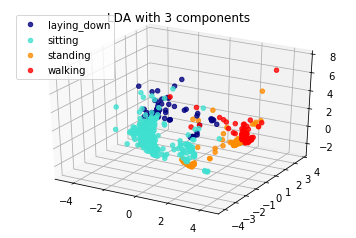

In [77]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lw = 1
colors = ['navy', 'turquoise', 'darkorange','red']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
lda = LinearDiscriminantAnalysis(n_components=3)
x_lda = lda.fit_transform(x,y)
for color, i, target_name in zip(colors, [1, 2, 3, 4], data.activity_name.unique()):
    ax.scatter(x_lda[y.activity_label == i, 0], x_lda[y.activity_label == i, 1], 
                x_lda[y.activity_label == i, 2], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA with 3 components')

Text(0.5,0.92,'Statistic feature (var) in 3D ')

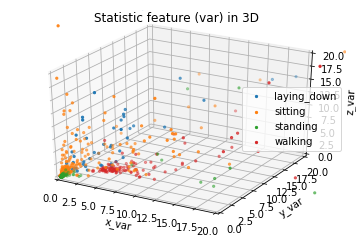

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for color, i, target_name in zip(colors, [1, 2, 3, 4], data.activity_name.unique()):
    xs = x.loc[y.activity_label == i, 'x_var']
    ys = x.loc[y.activity_label == i, 'y_var']
    zs = x.loc[y.activity_label == i, 'z_var']
    ax.scatter(xs, ys, zs, s = 5, label=target_name)
    
ax.set_xlabel('x_var');ax.set_ylabel('y_var');ax.set_zlabel('z_var')
ax.set_xbound(0,20);ax.set_ybound(0,20);ax.set_zbound(0,20)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title("Statistic feature (var) in 3D ")

## Plotting Helpers

In [79]:
def show_stats(y_test, y_pred, y_pred_prob):
    import itertools
    from sklearn import linear_model
    from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score, accuracy_score, recall_score, f1_score

    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

    cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1,2,3])
    plot_confusion_matrix(cnf_matrix, ['laying down', 'sitting', 'standing', 'walking'], title='Confusion Matrix')

 #   fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,0], pos_label=0)
#    plt.plot(fpr, tpr, label='AUC =  %.3f' % roc_auc_score(y_test, y_pred_prob[:,0]))
  #  plt.title('ROC Curve')
   # plt.ylabel('True Positive Rate')
    #plt.xlabel('False Positive Rate')
    #plt.legend()
    #plt.show()

    print('F1-score = %0.3f, Accuracy = %.3f' % (f1_score(y_test, y_pred, average='macro'), accuracy_score(y_test, y_pred), ))

## KNN

In [80]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors = 5)
knn_clf.fit(x_train, y_train)
knn_clf.score(x_test, y_test)
accu = np.mean(cross_val_score(knn_clf, x, y.activity_label, cv=10))
print("average accuracy for knn(k=5) is {0}".format(round(accu,5)))
crosstab = pd.crosstab(y_test.activity_label, knn_clf.predict(x_test),
                          rownames=['True'], colnames=['Predicted'],
                          margins=True)
crosstab



average accuracy for knn(k=5) is 0.92226


/Users/Jonny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


Predicted,1,2,3,4,All
True,,,,,
1,34,28,63,5,130
2,75,60,0,0,135
3,0,1,160,1,162
4,0,10,0,100,110
All,109,99,223,106,537


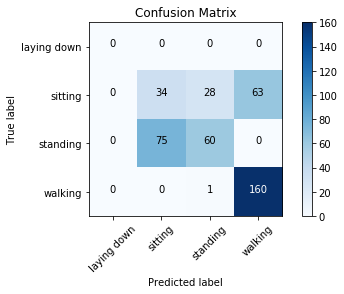

F1-score = 0.639, Accuracy = 0.659


In [81]:
show_stats(y_test.activity_label, knn_clf.predict(x_test), knn_clf.predict_proba(x_test))

## Decision tree

In [82]:
## decision tree classifier
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf.fit(x_train, y_train.activity_label)
accu = np.mean(cross_val_score(dt_clf, x, y.activity_label, cv=10))
print("average accuracy for decisiontree is {0}".format(round(accu,5)))
crosstab = pd.crosstab(y_test.activity_label, dt_clf.predict(x_test),
                          rownames=['True'], colnames=['Predicted'],
                          margins=True)
crosstab



average accuracy for decisiontree is 0.8941


Predicted,1,2,3,4,All
True,,,,,
1,40,22,66,2,130
2,41,74,0,20,135
3,0,0,160,2,162
4,9,34,1,66,110
All,90,130,227,90,537


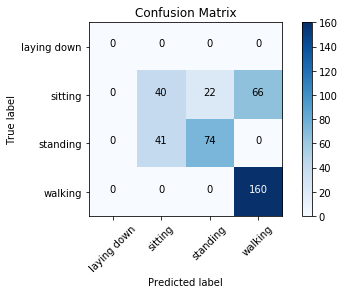

F1-score = 0.601, Accuracy = 0.633


In [83]:
show_stats(y_test.activity_label, dt_clf.predict(x_test), dt_clf.predict_proba(x_test))

## Random Forest 

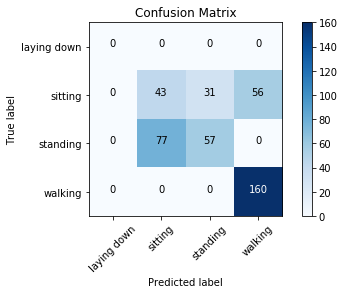

F1-score = 0.595, Accuracy = 0.613


In [84]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train.activity_label)
y_preds = rf_clf.predict(x_test)
y_pred_prob = rf_clf.predict_proba(x_test)

show_stats(y_test.activity_label, y_preds, y_pred_prob)

## Logistic Regression

In [85]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(x_train, y_train.activity_label)

accu = np.mean(cross_val_score(lr_clf, y, y.activity_label, cv=10))
print("Average train accuracy for logistic regression is {0}".format(round(accu,5)))
crosstab = pd.crosstab(y_test.activity_label, lr_clf.predict(x_test),
                          rownames=['True'], colnames=['Predicted'],
                          margins=True)
crosstab


Average train accuracy for logistic regression is 1.0


Predicted,1,2,3,4,All
True,,,,,
1,21,44,59,6,130
2,25,110,0,0,135
3,0,0,158,4,162
4,37,18,3,52,110
All,83,172,220,62,537


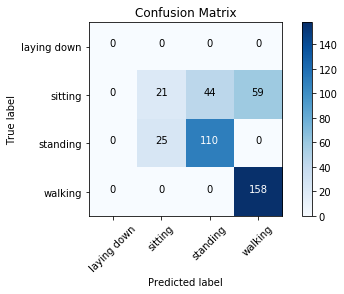

F1-score = 0.586, Accuracy = 0.635


In [86]:
show_stats(y_test.activity_label, lr_clf.predict(x_test), lr_clf.predict_proba(x_test))

## SVM

In [90]:
#SVM
from sklearn.svm import SVC

svc_clf = SVC(probability=True, decision_function_shape='ovr')
svc_clf.fit(x_train, y_train.activity_label)

accu = np.mean(cross_val_score(svc_clf, y, y.activity_label, cv=10))
print("average accuracy for SVM is {0}".format(round(accu,5)))
crosstab = pd.crosstab(y_test.activity_label, svc_clf.predict(x_test),
                          rownames=['True'], colnames=['Predicted'],
                          margins=True)

crosstab

average accuracy for SVM is 1.0


Predicted,4,All
True,,
1,130,130
2,135,135
3,162,162
4,110,110
All,537,537


[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

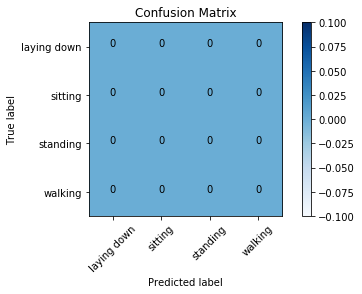

F1-score = 0.085, Accuracy = 0.205


/Users/Jonny/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [91]:
show_stats(y_test.activity_label, svc_clf.predict(x_test), svc_clf.predict_proba(x_test))